In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
BASE_DIR = "data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR  = os.path.join(BASE_DIR, "test")
WORK_DIR  = "work_pytorch"
os.makedirs(WORK_DIR, exist_ok=True)

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16   # safe for RTX 2050
EPOCHS = 20       # Increased for better convergence
LR = 1e-4
SEED = 42

In [4]:
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [6]:
print("Train samples:", len(train_ds), " Test samples:", len(test_ds))
print("Classes:", train_ds.classes)

Train samples: 36545  Test samples: 15338
Classes: ['fake', 'real']


In [7]:
model = create_model("xception", pretrained=True, num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

c:\Users\shrav\Deepfake-Detection-System\myenv\lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [8]:
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    acc = correct / total
    print(f"Epoch {epoch+1}: Train Loss={total_loss/total:.4f}, Acc={acc:.4f}")

torch.save(model.state_dict(), os.path.join(WORK_DIR, "xception_best.pth"))

Epoch 1: Train Loss=0.3976, Acc=0.8128


Epoch 2: Train Loss=0.2053, Acc=0.9188


Epoch 3: Train Loss=0.1369, Acc=0.9474


Epoch 4: Train Loss=0.1016, Acc=0.9612


Epoch 5: Train Loss=0.0798, Acc=0.9695


Epoch 6: Train Loss=0.0662, Acc=0.9754


Epoch 7: Train Loss=0.0585, Acc=0.9776


Epoch 8: Train Loss=0.0529, Acc=0.9805


Epoch 9: Train Loss=0.0469, Acc=0.9822


Epoch 10: Train Loss=0.0440, Acc=0.9826


In [9]:
model.eval()
all_labels, all_probs = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:,1]  # probability of "fake"

        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = torch.tensor(all_labels).numpy()
all_probs = torch.tensor(all_probs).numpy()
preds = (all_probs > 0.5).astype(int)

Testing: 100%|██████████| 959/959 [01:44<00:00,  9.19it/s]


In [10]:
print("ROC AUC:", roc_auc_score(all_labels, all_probs))
print(classification_report(all_labels, preds, target_names=train_ds.classes))
print("Confusion Matrix:\n", confusion_matrix(all_labels, preds))

ROC AUC: 0.7992363177703948
              precision    recall  f1-score   support

        fake       0.87      0.76      0.81     11469
        real       0.49      0.66      0.56      3869

    accuracy                           0.74     15338
   macro avg       0.68      0.71      0.69     15338
weighted avg       0.77      0.74      0.75     15338

Confusion Matrix:
 [[8769 2700]
 [1318 2551]]


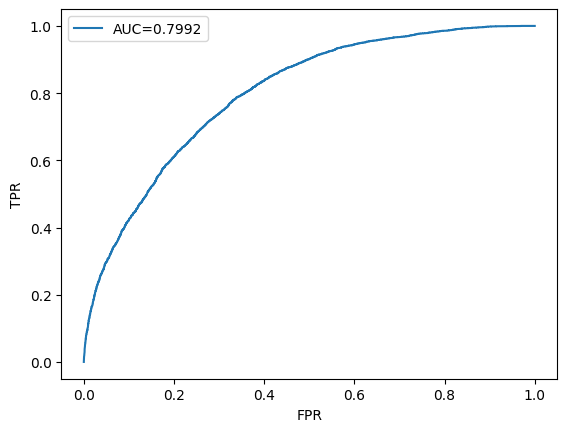

In [11]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(all_labels, all_probs):.4f}")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.savefig(os.path.join(WORK_DIR, "roc_curve.png"))